In [1]:
import sys
sys.path.append('/Users/nmontes/OneDrive/Documentos/PhD/ngames/ngames')
import matplotlib.pyplot as plt
from extensivegames import ExtensiveFormGame, plot_game, backward_induction,\
subgame_perfect_equilibrium, DFS_equilibria_paths

In [2]:
fishing_game = ExtensiveFormGame(title='Fishing game C1')

# add the two positions for the two fishers
fishing_game.add_positions('fisher 1', 'fisher 2')

# add the nodes to the graph
fishing_game.add_node(1, position_turn='fisher 1', is_root=True)
fishing_game.add_node(2, position_turn='fisher 2')
fishing_game.add_node(3, position_turn='fisher 2')
fishing_game.add_node(4, position_turn='fisher 1')
fishing_game.add_node(5)
fishing_game.add_node(6)
fishing_game.add_node(7, position_turn='fisher 1')
fishing_game.add_node(8, position_turn='fisher 2')
fishing_game.add_node(9, position_turn='fisher 2')
fishing_game.add_node(10, position_turn='fisher 2')
fishing_game.add_node(11, position_turn='fisher 2')
fishing_game.add_node(12, position_turn='chance')
fishing_game.add_node(13)
fishing_game.add_node(14)
fishing_game.add_node(15, position_turn='chance')
fishing_game.add_node(16, position_turn='chance')
fishing_game.add_node(17)
fishing_game.add_node(18)
fishing_game.add_node(19, position_turn='chance')
for i in range(20, 28):
    fishing_game.add_node(i)

# add the edges to the graph
fishing_game.add_edge(1, 2, label='go to spot 1')
fishing_game.add_edge(1, 3, label='go to spot 2')
fishing_game.add_edge(2, 4, label='go to spot 1')
fishing_game.add_edge(2, 5, label='go to spot 2')
fishing_game.add_edge(3, 6, label='go to spot 1')
fishing_game.add_edge(3, 7, label='go to spot 2')
fishing_game.add_edge(4, 8, label='stay')
fishing_game.add_edge(4, 9, label='leave')
fishing_game.add_edge(7, 10, label='stay')
fishing_game.add_edge(7, 11, label='leave')

fishing_game.add_edge(8, 12, label='stay')
fishing_game.add_edge(8, 13, label='leave')
fishing_game.add_edge(9, 14, label='stay')
fishing_game.add_edge(9, 15, label='leave')
fishing_game.add_edge(10, 16, label='stay')
fishing_game.add_edge(10, 17, label='leave')
fishing_game.add_edge(11, 18, label='stay')
fishing_game.add_edge(11, 19, label='leave')

fishing_game.add_edge(12, 20, label='1 wins')
fishing_game.add_edge(12, 21, label='2 wins')
fishing_game.add_edge(15, 22, label='1 wins')
fishing_game.add_edge(15, 23, label='2 wins')
fishing_game.add_edge(16, 24, label='1 wins')
fishing_game.add_edge(16, 25, label='2 wins')
fishing_game.add_edge(19, 26, label='1 wins')
fishing_game.add_edge(19, 27, label='2 wins')

# add imperfect information, equivalent to having players take the actions simultaneously
fishing_game.set_information_partition('fisher 2', {2,3}, {8,9}, {10,11})

# Rule configuration C1 (default)

See page 85 in E. Ostrom, R. Gardner, J. Walker, Rules, Games, and Common-Pool Resources, The University of Michigan Press, Ann Arbor, 1994. https://doi.org/10.3998/mpub.9739.

First, build the default situation as an extensive-form game. Two fishers competing for two fishing spots, the first spot being better than the other.

The utilities and probability at chance nodes of the game are parametrized with the following variables:

* $v_i$: economical value of the $i$-th spot. It is assumed that the first spot is the better one, so $v_1>v_2$.

* $P$: the probability that fisher 1 wins the fight if one happens. It is assumed that fisher 1 is the stronger one, so $P>0.5$. Then, the probability that fisher 2 wins a fight is $(1-P)<0.5$.

* $c$: cost of travel between the two spots.

* $d$: damage incurred to the loser of the fight.

$w(j, i)$ denotes the *expected* value for fisher $j$ of having a fight at spot $i$:

\begin{align}
    w(1,i) =& Pv_i+(1-P)(-d)\\
    w(2,i) =& (1-P)v_i+P(-d)
\end{align}

Start assigning utilities with made-up values.

In [3]:
# parameters
v1, v2 = 5, 3
P = 0.6
c = 0.5
d = 2

def set_parameters(v1: float, v2: float, P: float, c: float, d: float, 
                   game: ExtensiveFormGame):
    w11 = P*v1+(1-P)*(-d)
    w12 = P*v2+(1-P)*(-d)
    w21 = (1-P)*v1+P*(-d)
    w22 = (1-P)*v2+P*(-d)
    # set utility parameters and probabilities over outgoing edges at
    # chance nodes
    game.set_utility(5, {'fisher 1':v1, 'fisher 2':v2})
    game.set_utility(6, {'fisher 1':v2, 'fisher 2':v1})
    game.set_utility(13, {'fisher 1':v1, 'fisher 2':v2-c})
    game.set_utility(14, {'fisher 1':v2-c, 'fisher 2':v1})
    game.set_utility(17, {'fisher 1':v2, 'fisher 2':v1-c})
    game.set_utility(18, {'fisher 1':v2-c, 'fisher 2':v1})
    game.set_probability_distribution(12, {(12,20):P, (12,21):(1-P)})
    game.set_probability_distribution(15, {(15,22):P, (15,23):(1-P)})
    game.set_probability_distribution(16, {(16,24):P, (16,25):(1-P)})
    game.set_probability_distribution(19, {(19,26):P, (19,27):(1-P)})
    game.set_utility(20, {'fisher 1':v1, 'fisher 2':-d})
    game.set_utility(21, {'fisher 1':-d, 'fisher 2':v1})
    game.set_utility(22, {'fisher 1':v2-c, 'fisher 2':-c-d})
    game.set_utility(23, {'fisher 1':-c-d, 'fisher 2':v2-c})
    game.set_utility(24, {'fisher 1':v2, 'fisher 2':-d})
    game.set_utility(25, {'fisher 1':-d, 'fisher 2':v2})
    game.set_utility(26, {'fisher 1':v1-c, 'fisher 2':-c-d})
    game.set_utility(27, {'fisher 1':-c-d, 'fisher 2':v1-c})
    
    return (w11, w12), (w21, w22)
    
_ = set_parameters(v1, v2, P, c, d, fishing_game)

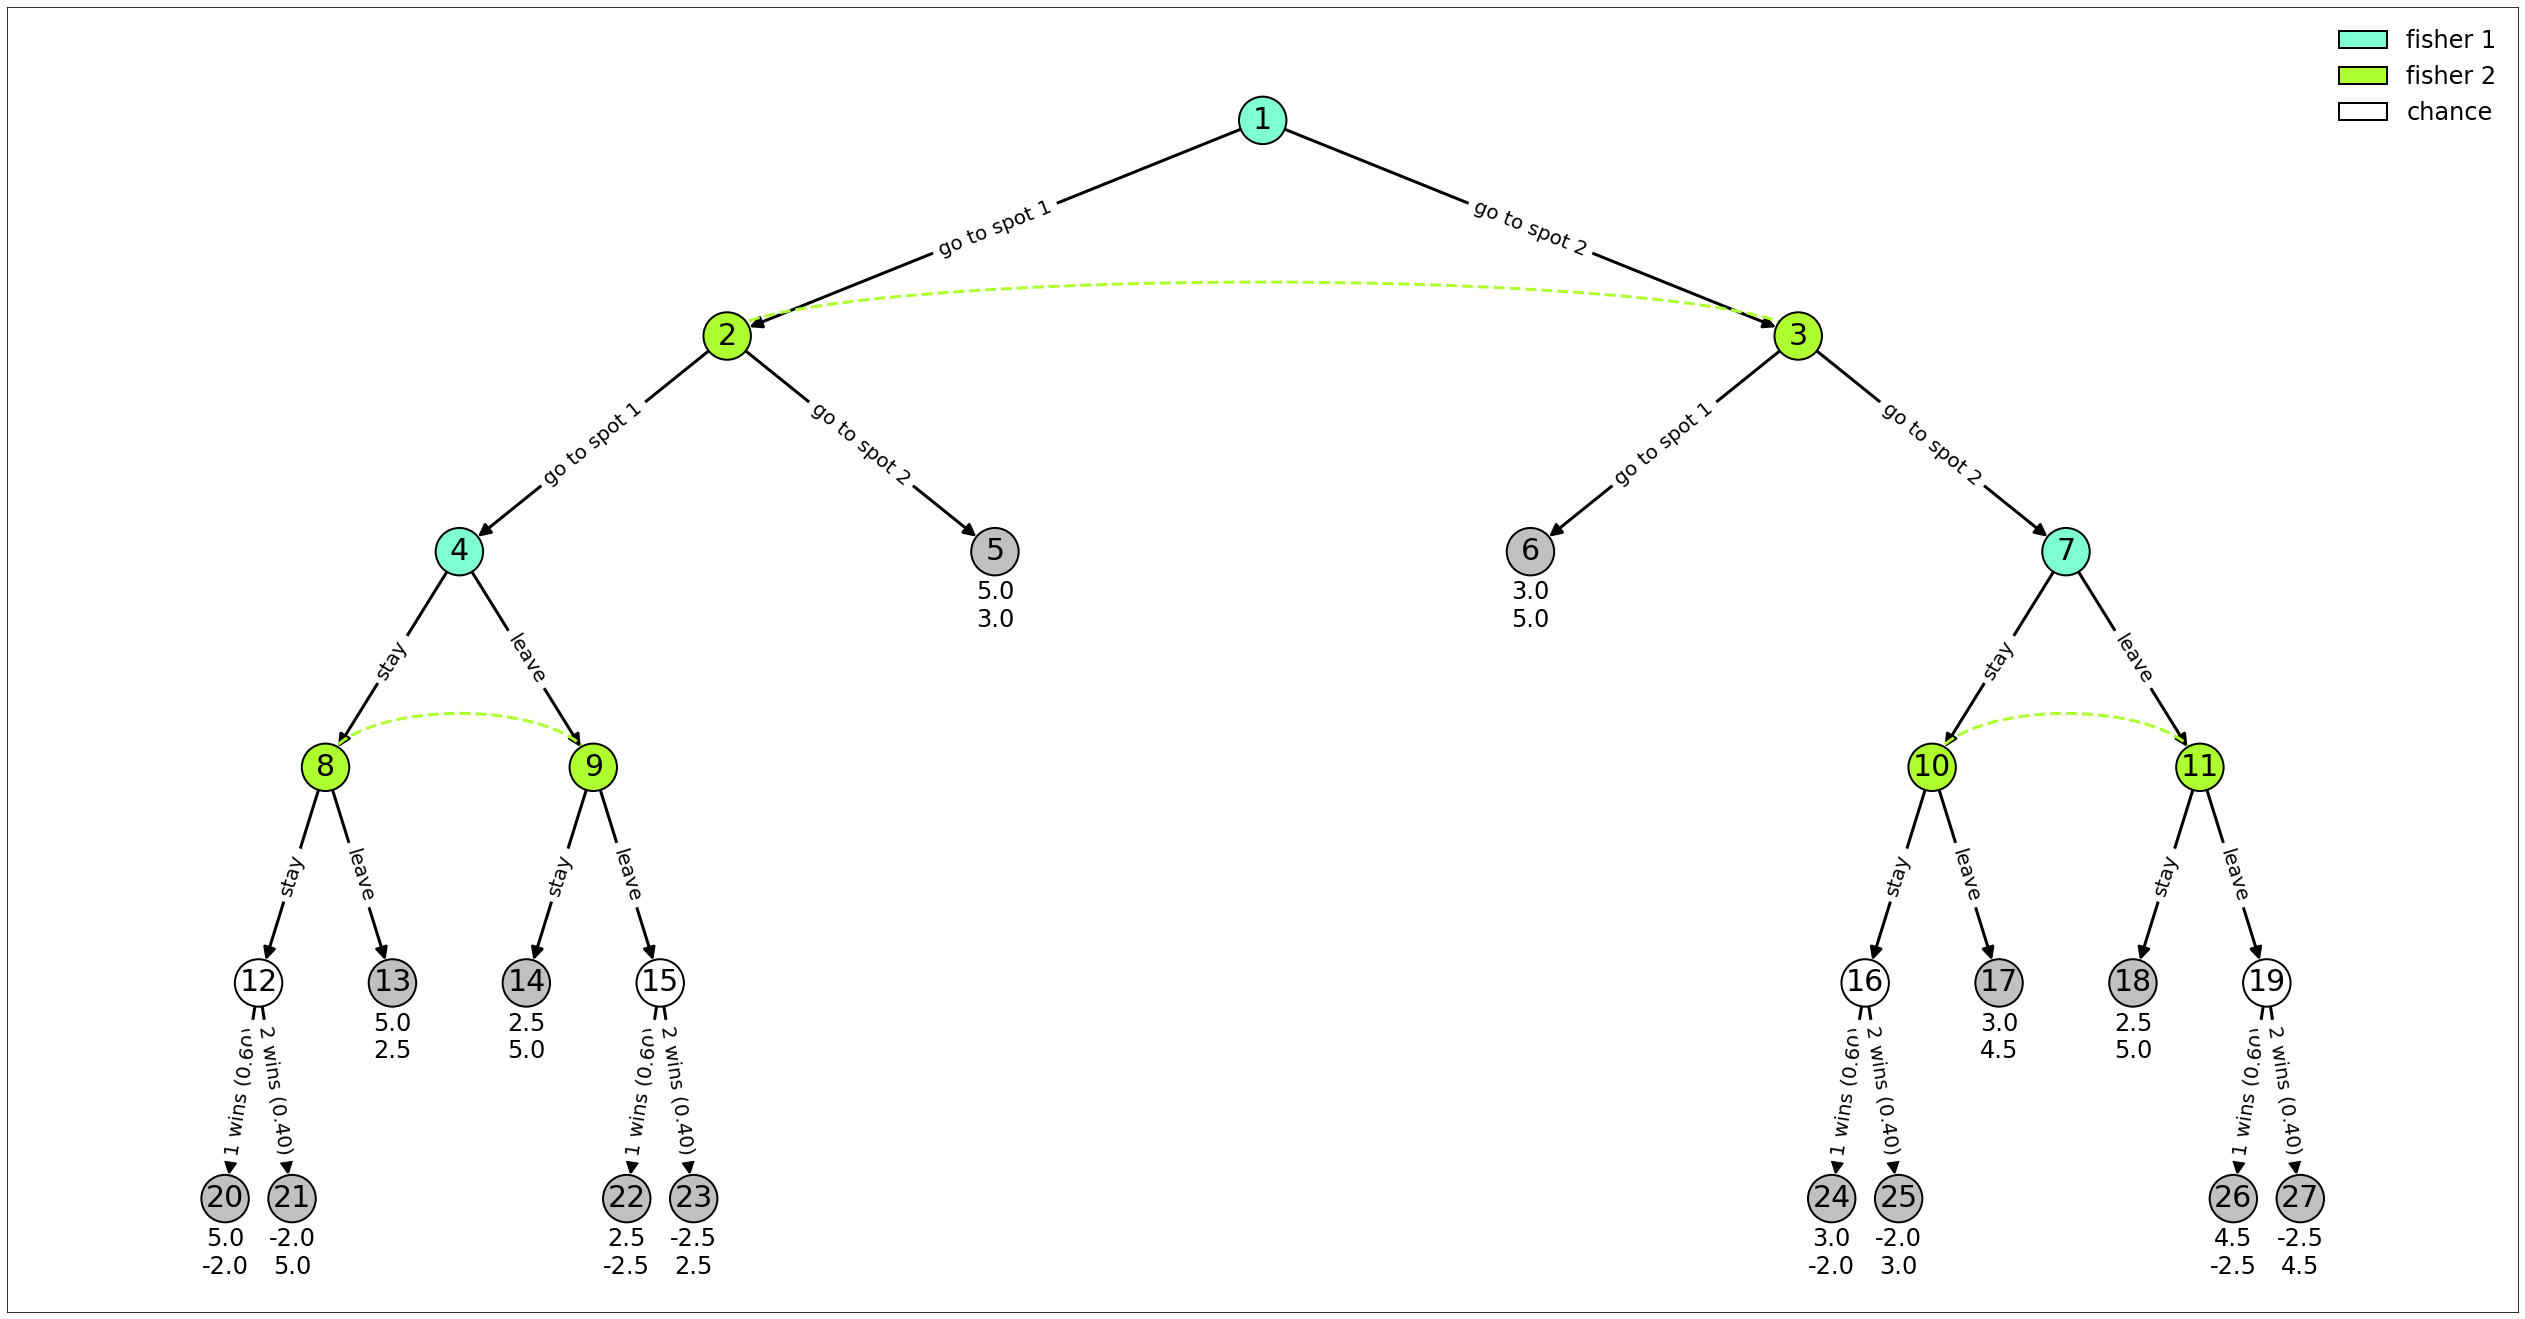

In [4]:
# default keywords for rendering the figure
my_fig_kwargs = dict(figsize=(45,24), frameon=False)
my_node_kwargs = dict(font_size=30, node_size=2250, edgecolors='k',
                      linewidths=2)
my_edge_kwargs = dict(arrowsize=25, width=3)
my_edge_labels_kwargs = dict(font_size=20)
my_patch_kwargs = dict(linewidth=2)
my_legend_kwargs = dict(fontsize=24, loc='upper right', edgecolor='white')
my_utility_label_kwargs = dict(horizontalalignment='center', fontsize=24)
my_info_sets_kwargs = dict(linestyle='--', linewidth=3)

position_colors =  {'fisher 1':'aquamarine', 'fisher 2':'greenyellow'}

fig = plot_game(fishing_game,
                position_colors,
                fig_kwargs=my_fig_kwargs,
                node_kwargs=my_node_kwargs,
                edge_kwargs=my_edge_kwargs,
                edge_labels_kwargs=my_edge_labels_kwargs,
                patch_kwargs=my_patch_kwargs,
                legend_kwargs=my_legend_kwargs,
                utility_label_kwargs=my_utility_label_kwargs,
                utility_label_shift=0.07,
                info_sets_kwargs=my_info_sets_kwargs)

fig.savefig('fishing_game_C1.png', bbox_inches='tight')

Compute the subgame perfect equilibria strategy:

In [5]:
spe = subgame_perfect_equilibrium(fishing_game)

Compute the paths of play that arise from following the subgame perfect equilibria strategy, alongside with the probability of being played. It is necessary to include probabilities since there are chance nodes:

In [6]:
path_store = []
DFS_equilibria_paths(fishing_game, fishing_game.game_tree.root, spe, [], 1,
                     path_store)
print("Path -- Probability")
print("-------------------")
for (path, prob) in path_store:
    print("{} -- {:.2f}".format(path, prob))

Path -- Probability
-------------------
[1, 'go to spot 1', 2, 'go to spot 2', 5] -- 1.00


In order to introduce the later changes to the game in the other rule configurations, establish that the utility at the terminal nodes can be computed as:

*Utility* = (*payoff of the outcome*) + (*cost of the path of actions to get there*)

__Costs assigned to actions__:

| Action       | Cost     |
|--------------|----------|
| Go to spot 1 | 0        |
| Go to spot 2 | 0        |
| Stay         | 0        |
| Leave        | -c (c>0) |

__Costs assigned to payoffs__:

| Outcome | Payoff |
|---------|--------|
| Fish at spot 1 | $v_1$ |
| Fish at spot 2 | $v_2$ |
| Looser of fight* | -d (d>0) |

*: in more general terms, a fight can be encompassed under the term "competition". This will make the transition from C1 to C2 easier.

To reproduce the analysis of the game by Ostrom in an automated way, I use backward induction. This is not technically correct because the game is imperfect information, but for the moment the focus is not so much on the correctness of the solution concept.

The first three cases fulfill $w(1, 1)>v_2-c$ and $w(2, 1)>v_2-c$:

* Case 1: $w(1,1)>v_2;\;w(2,1)>v_2$

* Case 2: $w(1,1)>v_2;\;w(2,1)<v_2$

* Case 3: $w(1,1)<v_2;\;w(2,1)<v_2$

The other two cases are:

* Case 4: $w(1,1)>v_2-c;\;w(2,1)<v_2-c$

* Case 5: $w(1,1)<v_2-c;\;w(2,1)<v_2-c$

## Case C1-1

$w(1,1)>v_2;\;w(2,1)>v_2$

As predicted by Ostrom, in the equilibrium both fishers go to spot 1, stay there and fight.

In [7]:
v1, v2 = 10, 2
P = 0.55
c = 1
d = 2

(w11, w12), (w21, w22) = set_parameters(v1, v2, P, c, d, fishing_game)
print("w(1,1) = {:.1f}".format(w11))
print("w(2,1) = {:.1f}".format(w21))
print("v2 = {:.1f}".format(v2))

spe = subgame_perfect_equilibrium(fishing_game)
path_store = []
DFS_equilibria_paths(fishing_game, fishing_game.game_tree.root, spe, [], 1,
                     path_store)
print("\nPath -- Probability")
print("-------------------")
for (path, prob) in path_store:
    print("{} -- {:.2f}".format(path, prob))

w(1,1) = 4.6
w(2,1) = 3.4
v2 = 2.0

Path -- Probability
-------------------
[1, 'go to spot 1', 2, 'go to spot 1', 4, 'stay', 8, 'stay', 12, '1 wins', 20] -- 0.55
[1, 'go to spot 1', 2, 'go to spot 1', 4, 'stay', 8, 'stay', 12, '2 wins', 21] -- 0.45


## Case C1-2

$w(1,1)>v_2;\;w(2,1)<v_2$

As predicted by Ostrom, in the equilibrium the stronger fisher 1 ($P>0.5$) goes to spot 1, the weaker fisher 2 goes to spot 2.

In [8]:
v1, v2 = 10, 4
P = 0.6
c = 1
d = 2

(w11, w12), (w21, w22) = set_parameters(v1, v2, P, c, d, fishing_game)
print("w(1,1) = {:.1f}".format(w11))
print("w(2,1) = {:.1f}".format(w21))
print("v2 = {:.1f}".format(v2))

spe = subgame_perfect_equilibrium(fishing_game)
path_store = []
DFS_equilibria_paths(fishing_game, fishing_game.game_tree.root, spe, [], 1,
                     path_store)
print("\nPath -- Probability")
print("-------------------")
for (path, prob) in path_store:
    print("{} -- {:.2f}".format(path, prob))

w(1,1) = 5.2
w(2,1) = 2.8
v2 = 4.0

Path -- Probability
-------------------
[1, 'go to spot 1', 2, 'go to spot 2', 5] -- 1.00


## Case C1-3

$w(1,1)<v_2;\;w(2,1)<v_2$

As predicted by Ostrom, again in the equilibrium the stronger fisher 1 ($P>0.5$) goes to spot 1, the weaker fisher 2 goes to spot 2.

Ostrom points out that there is another pure strategy equilibrium in which fisher 1 goes to the worse spot 2, and fisher 2 goes to the better spot 1. However, that outcome is part of a Nash equilibrium that is not sequentially rational (?).

In [9]:
v1, v2 = 6, 4
P = 0.6
c = 1
d = 2

(w11, w12), (w21, w22) = set_parameters(v1, v2, P, c, d, fishing_game)
print("w(1,1) = {:.1f}".format(w11))
print("w(2,1) = {:.1f}".format(w21))
print("v2 = {:.1f}".format(v2))

spe = subgame_perfect_equilibrium(fishing_game)
path_store = []
DFS_equilibria_paths(fishing_game, fishing_game.game_tree.root, spe, [], 1,
                     path_store)
print("\nPath -- Probability")
print("-------------------")
for (path, prob) in path_store:
    print("{} -- {:.2f}".format(path, prob))

w(1,1) = 2.8
w(2,1) = 1.2
v2 = 4.0

Path -- Probability
-------------------
[1, 'go to spot 1', 2, 'go to spot 2', 5] -- 1.00


## Case C1-4

$w(1,1)>v_2-c;\;w(2,1)<v_2-c$

As predicted by Ostrom, again in the equilibrium the stronger fisher 1 goes to spot 1, the weaker fisher 2 goes to spot 2.

In [10]:
v1, v2 = 10, 5
P = 0.6
c = 1
d = 2

(w11, w12), (w21, w22) = set_parameters(v1, v2, P, c, d, fishing_game)
print("w(1,1) = {:.1f}".format(w11))
print("w(2,1) = {:.1f}".format(w21))
print("v2-c = {:.1f}".format(v2-c))

spe = subgame_perfect_equilibrium(fishing_game)
path_store = []
DFS_equilibria_paths(fishing_game, fishing_game.game_tree.root, spe, [], 1,
                     path_store)
print("\nPath -- Probability")
print("-------------------")
for (path, prob) in path_store:
    print("{} -- {:.2f}".format(path, prob))

w(1,1) = 5.2
w(2,1) = 2.8
v2-c = 4.0

Path -- Probability
-------------------
[1, 'go to spot 1', 2, 'go to spot 2', 5] -- 1.00


## Case C1-5

$w(1,1)<v_2-c;\;w(2,1)<v_2-c$

As predicted by Ostrom, again in the equilibrium the stronger fisher 1 goes to spot 1, the weaker fisher 2 goes to spot 2.

In [11]:
v1, v2 = 7, 5
P = 0.6
c = 1
d = 2

(w11, w12), (w21, w22) = set_parameters(v1, v2, P, c, d, fishing_game)
print("w(1,1) = {:.1f}".format(w11))
print("w(2,1) = {:.1f}".format(w21))
print("v2-c = {:.1f}".format(v2-c))

spe = subgame_perfect_equilibrium(fishing_game)
path_store = []
DFS_equilibria_paths(fishing_game, fishing_game.game_tree.root, spe, [], 1,
                     path_store)
print("\nPath -- Probability")
print("-------------------")
for (path, prob) in path_store:
    print("{} -- {:.2f}".format(path, prob))

w(1,1) = 3.4
w(2,1) = 1.6
v2-c = 4.0

Path -- Probability
-------------------
[1, 'go to spot 1', 2, 'go to spot 2', 5] -- 1.00


# Rule configuration C2

First fisher in arrival has the right to fish at that spot for the remaining of the day.

In [12]:
fishing_game_C2 = ExtensiveFormGame(title='Fishing game C2')

# add the two positions for the two fishers
fishing_game_C2.add_positions('fisher 1', 'fisher 2')

# add the nodes to the graph
fishing_game_C2.add_node(1, position_turn='fisher 1', is_root=True)
fishing_game_C2.add_node(2, position_turn='fisher 2')
fishing_game_C2.add_node(3, position_turn='fisher 2')
fishing_game_C2.add_node(4, position_turn='chance')
fishing_game_C2.add_node(5)
fishing_game_C2.add_node(6)
fishing_game_C2.add_node(7, position_turn='chance')
fishing_game_C2.add_node(8, position_turn='fisher 2')
fishing_game_C2.add_node(9, position_turn='fisher 1')
fishing_game_C2.add_node(10, position_turn='fisher 2')
fishing_game_C2.add_node(11, position_turn='fisher 1')
for i in range(12, 15+1):
    fishing_game_C2.add_node(i)

# add the edges to the graph
fishing_game_C2.add_edge(1, 2, label='go to spot 1')
fishing_game_C2.add_edge(1, 3, label='go to spot 2')
fishing_game_C2.add_edge(2, 4, label='go to spot 1')
fishing_game_C2.add_edge(2, 5, label='go to spot 2')
fishing_game_C2.add_edge(3, 6, label='go to spot 1')
fishing_game_C2.add_edge(3, 7, label='go to spot 2')
fishing_game_C2.add_edge(4, 8, label='1 first')
fishing_game_C2.add_edge(4, 9, label='2 first')
fishing_game_C2.add_edge(7, 10, label='1 first')
fishing_game_C2.add_edge(7, 11, label='2 first')
fishing_game_C2.add_edge(8, 12, label='leave')
fishing_game_C2.add_edge(9, 13, label='leave')
fishing_game_C2.add_edge(10, 14, label='leave')
fishing_game_C2.add_edge(11, 15, label='leave')

# add imperfect information, equivalent to having players take the actions 
# simultaneously
fishing_game_C2.set_information_partition('fisher 2', {2,3}, {8}, {10})

The utilities and probability at chance nodes of the game are parametrized with the following variables:

* $v_i$: economical value of the $i$-th spot. It is assumed that the first spot is the better one, so $v_1>v_2$.

* $P$: the probability that fisher 1 gets to a spot first. It is assumed that fisher 1 has better technology than fisher 2, and hence $P>0.5$.

* $c$: cost of travel between the two spots.

$w(j, i)$ denotes the *expected* value for fisher $j$ of spot $i$ if the other fisher has gone there too:

\begin{align}
    w(1,i) =& Pv_i+(1-P)(v_{-i}-c)\\
    w(2,i) =& (1-P)v_i+P(v_{-i}-c)
\end{align}

In [13]:
# parameters
v1, v2 = 5, 3
P = 0.6
c = 0.5

def set_parameters_C2(v1: float, v2: float, P: float, c: float,
                      game: ExtensiveFormGame):
    w11 = P*v1+(1-P)*(v2-c)
    w12 = P*v2+(1-P)*(v1-c)
    w21 = (1-P)*v1+P*(v2-c)
    w22 = (1-P)*v2+P*(v1-c)
    # set utility parameters and probabilities over outgoing edges at 
    # chance nodes
    game.set_utility(5, {'fisher 1':v1, 'fisher 2':v2})
    game.set_utility(6, {'fisher 1':v2, 'fisher 2':v1})
    game.set_utility(12, {'fisher 1':v1, 'fisher 2':v2-c})
    game.set_utility(13, {'fisher 1':v2-c, 'fisher 2':v1})
    game.set_utility(14, {'fisher 1':v2, 'fisher 2':v1-c})
    game.set_utility(15, {'fisher 1':v1-c, 'fisher 2':v2})
    game.set_probability_distribution(4, {(4,8):P, (4,9):(1-P)})
    game.set_probability_distribution(7, {(7,10):P, (7,11):(1-P)})
    return (w11, w12), (w21, w22)
    
_ = set_parameters_C2(v1, v2, P, c, fishing_game_C2)

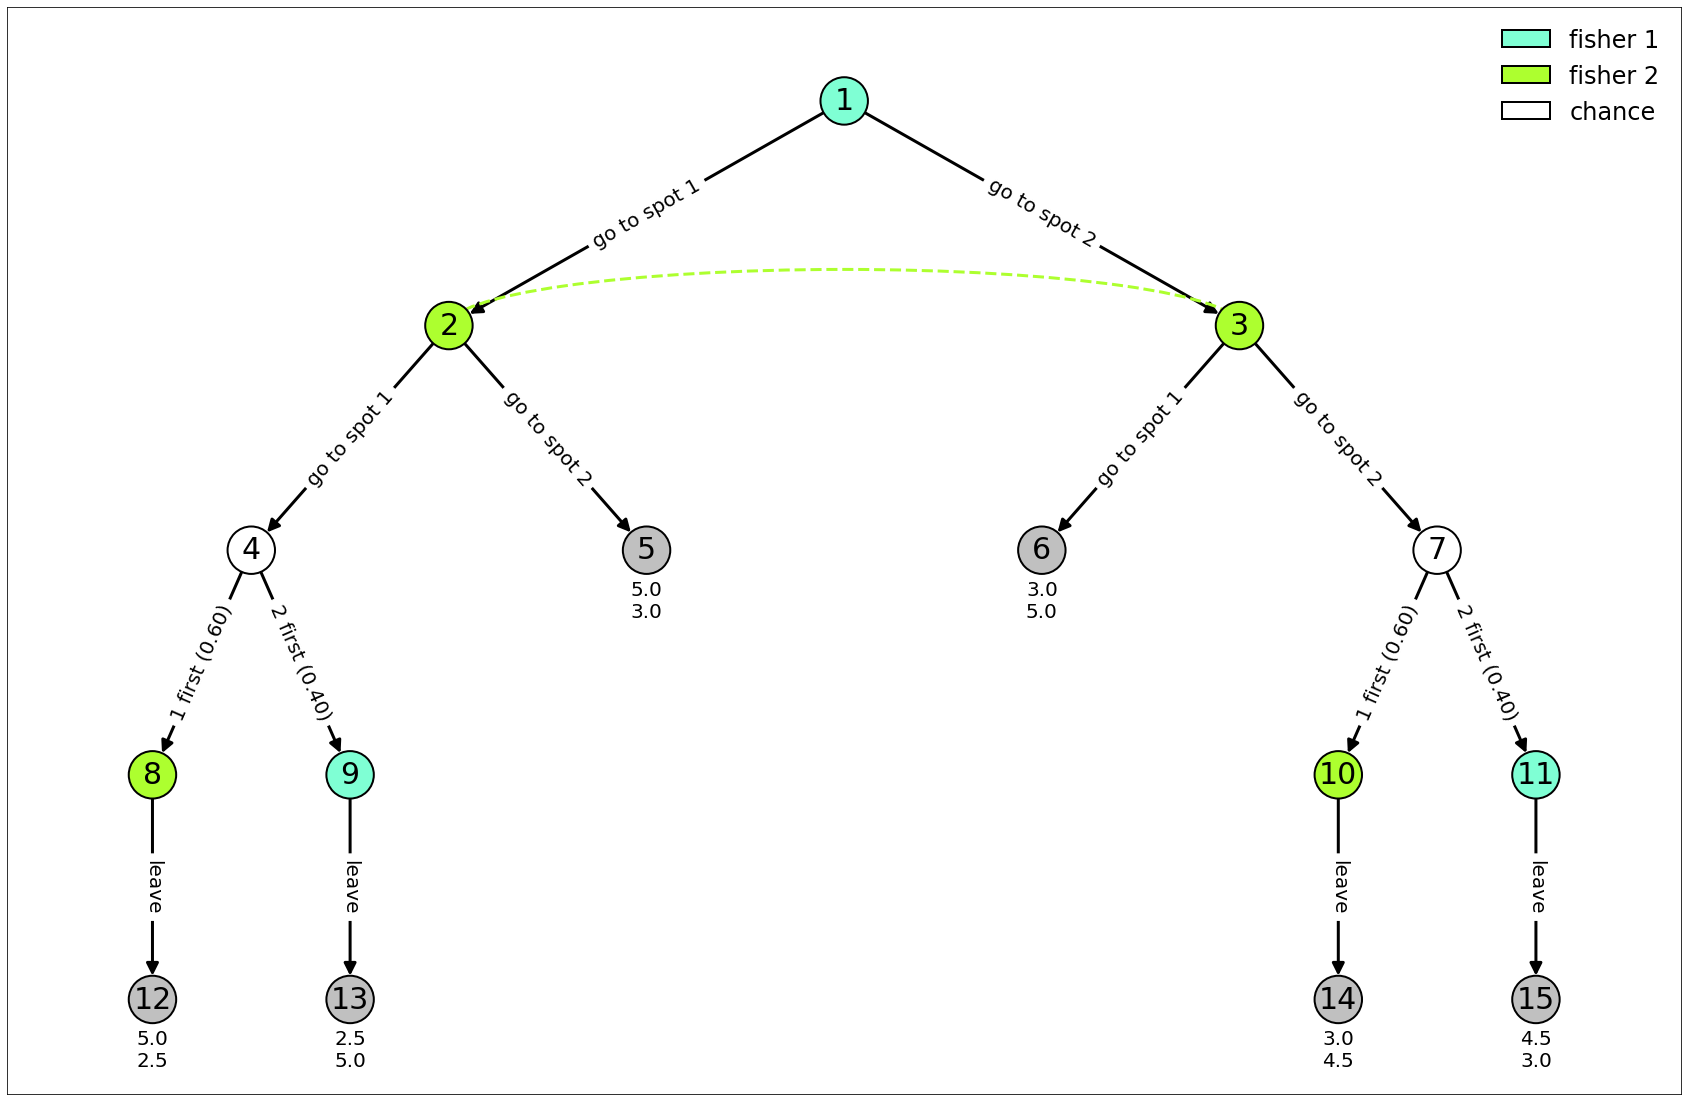

In [14]:
# default keywords for rendering the figure
my_fig_kwargs = dict(figsize=(30,20), frameon=False)
my_node_kwargs = dict(font_size=30, node_size=2250, edgecolors='k',
                      linewidths=2)
my_edge_kwargs = dict(arrowsize=25, width=3)
my_edge_labels_kwargs = dict(font_size=20)
my_patch_kwargs = dict(linewidth=2)
my_legend_kwargs = dict(fontsize=24, loc='upper right', edgecolor='white')
my_utility_label_kwargs = dict(horizontalalignment='center', fontsize=20)
my_info_sets_kwargs = dict(linestyle='--', linewidth=3)

position_colors =  {'fisher 1':'aquamarine', 'fisher 2':'greenyellow'}

fig = plot_game(fishing_game_C2,
                position_colors,
                fig_kwargs=my_fig_kwargs,
                node_kwargs=my_node_kwargs,
                edge_kwargs=my_edge_kwargs,
                edge_labels_kwargs=my_edge_labels_kwargs,
                patch_kwargs=my_patch_kwargs,
                legend_kwargs=my_legend_kwargs,
                utility_label_kwargs=my_utility_label_kwargs,
                utility_label_shift=0.06,
                info_sets_kwargs=my_info_sets_kwargs)

fig.savefig('fishing_game_C2.png', bbox_inches='tight', edgecolor=None)

**Changes to go from C1 to C2:**

* If fisher1.location == fisher2.location $\longrightarrow$ engage in a "competition". In the game tree of C1: "shortcut edge" from node 4 to node 12.

* Looser of fight from a final to an intermediate outcome (no longer a terminal node). 

* Change in payoff of outcome: $d>0\longrightarrow d=0$. Because fishers are engaged in a different, non-violent type of competition, it is not costly to lose the race. (this change might be redundant because being the looser is now an intermediate instead of a final outcome). 

* Additional edges: if fisher $i$ loses the competition $\longrightarrow$ fisher $i$ has to leave.

## Case C2-1

$w(1,1)>v_2;\;w(2,1)>v_2$

As predicted by Ostrom, in the equilibrium both fishers go to spot 1, and let chance decide who was first.

In [15]:
v1, v2 = 10, 2
P = 0.55
c = 1

(w11, w12), (w21, w22) = set_parameters_C2(v1, v2, P, c, fishing_game_C2)
print("w(1,1) = {:.1f}".format(w11))
print("w(2,1) = {:.1f}".format(w21))
print("v2 = {:.1f}".format(v2))

spe = subgame_perfect_equilibrium(fishing_game_C2)
path_store = []
DFS_equilibria_paths(fishing_game_C2, fishing_game_C2.game_tree.root, spe, [],
                     1, path_store)
print("\nPath -- Probability")
print("-------------------")
for (path, prob) in path_store:
    print("{} -- {:.2f}".format(path, prob))

w(1,1) = 6.0
w(2,1) = 5.0
v2 = 2.0

Path -- Probability
-------------------
[1, 'go to spot 1', 2, 'go to spot 1', 4, '1 first', 8, 'leave', 12] -- 0.55
[1, 'go to spot 1', 2, 'go to spot 1', 4, '2 first', 9, 'leave', 13] -- 0.45


## Case C2-2

$w(1,1)>v_2;\;w(2,1)<v_2$

As predicted by Ostrom, in the equilibrium fisher 1 (the faster) goes to spot 1, while fisher 2 (the slower) goes to spot 2.

In [16]:
v1, v2 = 10, 5
P = 0.7
c = 3

(w11, w12), (w21, w22) = set_parameters_C2(v1, v2, P, c, fishing_game_C2)
print("w(1,1) = {:.1f}".format(w11))
print("w(2,1) = {:.1f}".format(w21))
print("v2 = {:.1f}".format(v2))

spe = subgame_perfect_equilibrium(fishing_game_C2)
path_store = []
DFS_equilibria_paths(fishing_game_C2, fishing_game_C2.game_tree.root, spe, [],
                     1, path_store)
print("\nPath -- Probability")
print("-------------------")
for (path, prob) in path_store:
    print("{} -- {:.2f}".format(path, prob))

w(1,1) = 7.6
w(2,1) = 4.4
v2 = 5.0

Path -- Probability
-------------------
[1, 'go to spot 1', 2, 'go to spot 2', 5] -- 1.00


## Case C2-3

$w(1,1)<v_2;\;w(2,1)<v_2$

As predicted by Ostrom, in the equilibrium fisher 1 (the faster) goes to spot 1, while fisher 2 (the slower) goes to spot 2.

As in case C1-3, there is another Nash equilibria in which the most resourceful fisher 1 goes to the worse spot 2. However, that is not predicted by backward induction, possibly because that Nash equilibria is not sequentially rational.

In [17]:
v1, v2 = 10, 8
P = 0.55
c = 3

(w11, w12), (w21, w22) = set_parameters_C2(v1, v2, P, c, fishing_game_C2)
print("w(1,1) = {:.1f}".format(w11))
print("w(2,1) = {:.1f}".format(w21))
print("v2 = {:.1f}".format(v2))

spe = subgame_perfect_equilibrium(fishing_game_C2)
path_store = []
DFS_equilibria_paths(fishing_game_C2, fishing_game_C2.game_tree.root, spe, [],
                     1, path_store)
print("\nPath -- Probability")
print("-------------------")
for (path, prob) in path_store:
    print("{} -- {:.2f}".format(path, prob))

w(1,1) = 7.8
w(2,1) = 7.2
v2 = 8.0

Path -- Probability
-------------------
[1, 'go to spot 1', 2, 'go to spot 2', 5] -- 1.00


# Rule configuration C3

Fisher 1 announces first, and he has the right to go fish wherever he wants. If fisher 2 goes to the spot taken by fisher 1, he has to leave for the other spot.

In [18]:
fishing_game_C3 = ExtensiveFormGame(title='Fishing game C3')

# add the two positions for the two fishers
fishing_game_C3.add_positions('fisher 1', 'fisher 2')

# add the nodes to the graph
fishing_game_C3.add_node(1, position_turn='fisher 1', is_root=True)
fishing_game_C3.add_node(2, position_turn='fisher 2')
fishing_game_C3.add_node(3, position_turn='fisher 2')
fishing_game_C3.add_node(4, position_turn='fisher 2')
fishing_game_C3.add_node(5)
fishing_game_C3.add_node(6)
fishing_game_C3.add_node(7, position_turn='fisher 2')
fishing_game_C3.add_node(8)
fishing_game_C3.add_node(9)

# add the edges to the graph
fishing_game_C3.add_edge(1, 2, label='go to spot 1')
fishing_game_C3.add_edge(1, 3, label='go to spot 2')
fishing_game_C3.add_edge(2, 4, label='go to spot 1')
fishing_game_C3.add_edge(2, 5, label='go to spot 2')
fishing_game_C3.add_edge(3, 6, label='go to spot 1')
fishing_game_C3.add_edge(3, 7, label='go to spot 2')
fishing_game_C3.add_edge(4, 8, label='leave')
fishing_game_C3.add_edge(7, 9, label='leave')

The utilities are parametrized with the following variables:

* $v_i$: economical value of the $i$-th spot. It is assumed that the first spot is the better one, so $v_1>v_2$.

* $c$: cost of travel between the two spots.

In [19]:
# parameters
v1, v2 = 5, 3
P = 0.6
c = 0.5

fishing_game_C3.set_utility(5, {'fisher 1':v1, 'fisher 2':v2})
fishing_game_C3.set_utility(6, {'fisher 1':v2, 'fisher 2':v1})
fishing_game_C3.set_utility(8, {'fisher 1':v1, 'fisher 2':v2-c})
fishing_game_C3.set_utility(9, {'fisher 1':v2, 'fisher 2':v1-c})

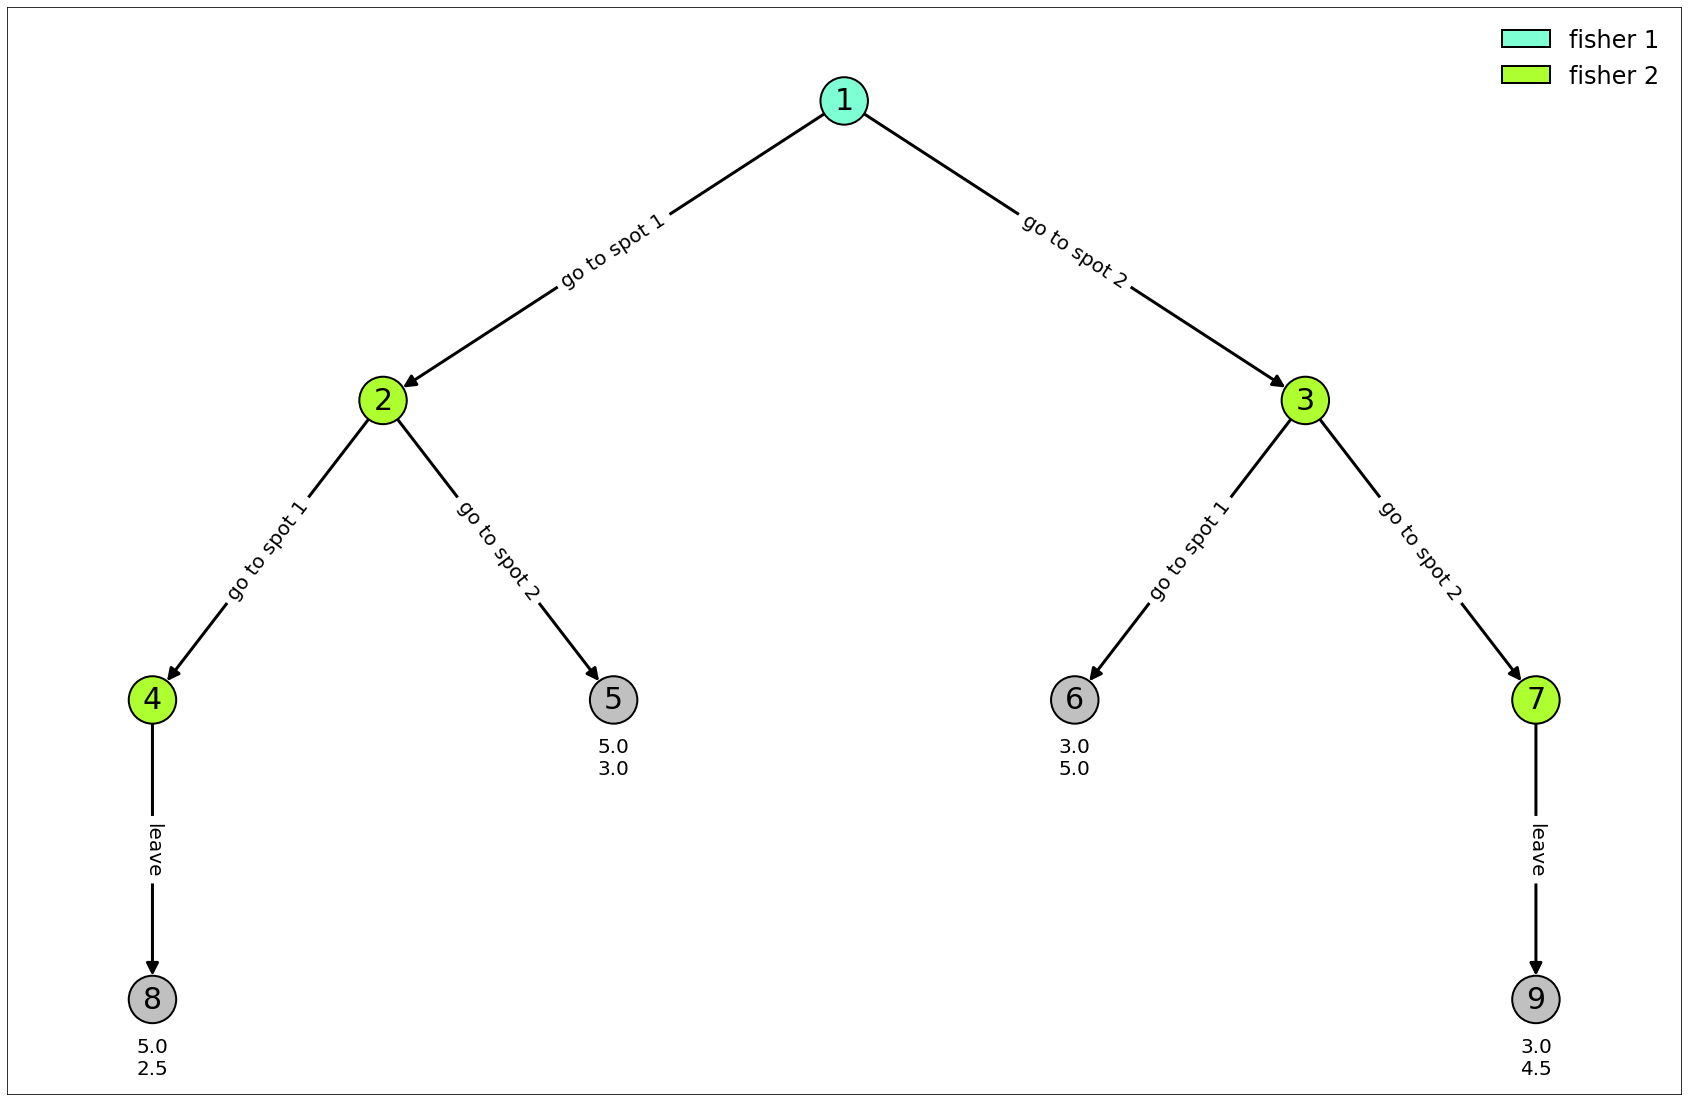

In [20]:
# default keywords for rendering the figure
my_fig_kwargs = dict(figsize=(30,20))
my_node_kwargs = dict(font_size=30, node_size=2250, edgecolors='k',
                      linewidths=2)
my_edge_kwargs = dict(arrowsize=25, width=3)
my_edge_labels_kwargs = dict(font_size=20)
my_patch_kwargs = dict(linewidth=2)
my_legend_kwargs = dict(fontsize=24, loc='upper right', edgecolor='white')
my_utility_label_kwargs = dict(horizontalalignment='center', fontsize=20)
my_info_sets_kwargs = dict(linestyle='--', linewidth=3)

position_colors =  {'fisher 1':'aquamarine', 'fisher 2':'greenyellow'}

fig = plot_game(fishing_game_C3,
                position_colors,
                fig_kwargs=my_fig_kwargs,
                node_kwargs=my_node_kwargs,
                edge_kwargs=my_edge_kwargs,
                edge_labels_kwargs=my_edge_labels_kwargs,
                patch_kwargs=my_patch_kwargs,
                legend_kwargs=my_legend_kwargs,
                utility_label_kwargs=my_utility_label_kwargs,
                utility_label_shift=0.05,
                info_sets_kwargs=my_info_sets_kwargs)

fig.savefig('fishing_game_C3.png', bbox_inches='tight')

**Changes to go from C1 to C3:**

* Fisher 1 announces: the information set {2,3} of fisher 2 gets split into two information sets {2}, {3} 

* If fisher$_i$.action == 'go to' fisher$_j$.location $\implies$ fisher$_i$.action $\leftarrow$ 'leave'. In terms of edges in the game tree from C1: direct edge from 4$\longrightarrow$13 and 7$\longrightarrow$17 

In [21]:
spe = subgame_perfect_equilibrium(fishing_game_C3)
path_store = []
DFS_equilibria_paths(fishing_game_C3, fishing_game_C3.game_tree.root, spe, [],
                     1, path_store)
print("\nPath -- Probability")
print("-------------------")
for (path, prob) in path_store:
    print("{} -- {:.2f}".format(path, prob))


Path -- Probability
-------------------
[1, 'go to spot 1', 2, 'go to spot 2', 5] -- 1.00


As predicted by Ostrom, in equilibrium the fisher who gets to announce first (fisher 1) goes to the best spot 1, and the other fish goes to the other spot. The second fisher will never go to the same spot that the first fisher went to, because $v_2>v_2-c$.

# Rule configuration C4

This configuration consists of a prearranged rotation of the game in rule configuration C3. It would consist of alternating between the game in C3 as presented before, and the same game in C3 but with fisher 1 and fisher swapped.

# Axelrod's norms game

In [22]:
norms_game = ExtensiveFormGame(title='Axelrod norms game')

norms_game.add_positions('i', 'j')
norms_game.add_node(1, position_turn='i', is_root=True)
norms_game.add_node(2, position_turn='chance')
norms_game.add_node(3)
norms_game.add_node(4, position_turn='j')
norms_game.add_node(5)
norms_game.add_node(6)
norms_game.add_node(7)

norms_game.add_edge(1, 2, 'defect')
norms_game.add_edge(1, 3, '~defect')
norms_game.add_edge(2, 4, 'j sees i')
norms_game.add_edge(2, 5, '~j sees i')
norms_game.add_edge(4, 6, 'punish')
norms_game.add_edge(4, 7, '~punish')

In [23]:
T = 3
H = -1
S = 0.6
P = -9
E = -2

norms_game.set_utility(3, {'i':0, 'j':0})
norms_game.set_utility(5, {'i':T, 'j':H})
norms_game.set_utility(6, {'i':P, 'j':E})
norms_game.set_utility(7, {'i':T, 'j':H})
norms_game.set_probability_distribution(2, {(2,4):S, (2,5):(1-S)})

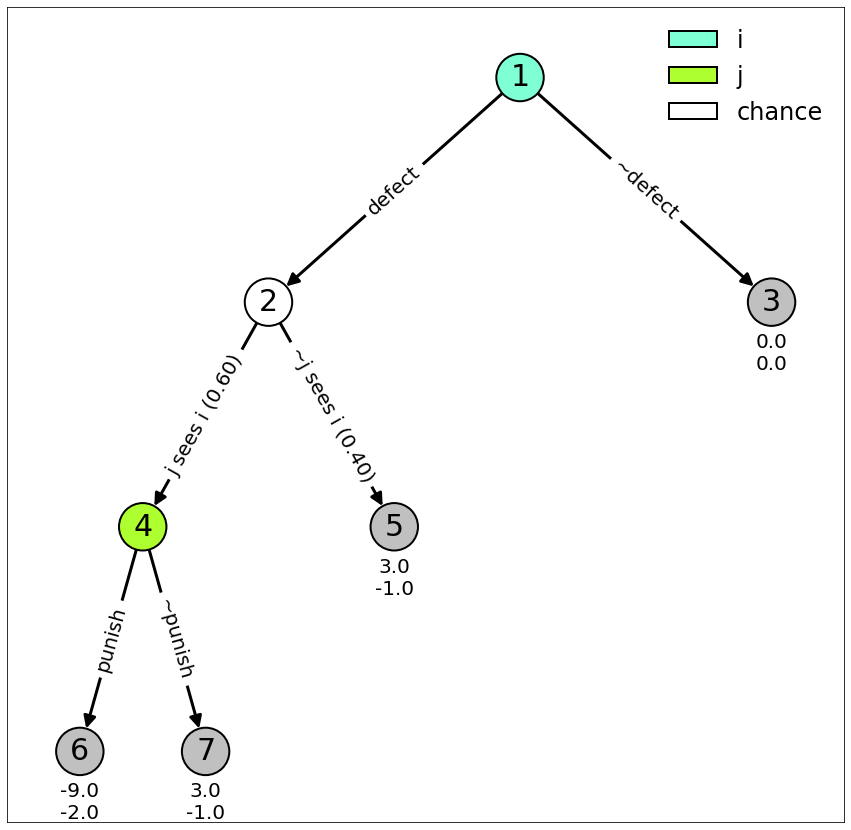

In [24]:
# default keywords for rendering the figure
my_fig_kwargs = dict(figsize=(15, 15), frameon=False)
my_node_kwargs = dict(font_size=30, node_size=2250, edgecolors='k',
                      linewidths=2)
my_edge_kwargs = dict(arrowsize=25, width=3)
my_edge_labels_kwargs = dict(font_size=20)
my_patch_kwargs = dict(linewidth=2)
my_legend_kwargs = dict(fontsize=24, loc='upper right', edgecolor='white')
my_utility_label_kwargs = dict(horizontalalignment='center', fontsize=20)
my_info_sets_kwargs = dict(linestyle='--', linewidth=3)

position_colors =  {'i':'aquamarine', 'j':'greenyellow'}

fig = plot_game(norms_game,
                position_colors,
                fig_kwargs=my_fig_kwargs,
                node_kwargs=my_node_kwargs,
                edge_kwargs=my_edge_kwargs,
                edge_labels_kwargs=my_edge_labels_kwargs,
                patch_kwargs=my_patch_kwargs,
                legend_kwargs=my_legend_kwargs,
                utility_label_kwargs=my_utility_label_kwargs,
                utility_label_shift=0.06,
                info_sets_kwargs=my_info_sets_kwargs)

fig.savefig('axelrod_norms_game.png', bbox_inches='tight', edgecolor=None)

**CASE 1:** $E<H$

Theoretical prediction: $i$ will defect but $j$ will not punishes if she detects $i$.

In [25]:
print("E = {:.1f}".format(E))
print("H = {:.1f}".format(H))

spe = subgame_perfect_equilibrium(norms_game)
path_store = []
DFS_equilibria_paths(norms_game, norms_game.game_tree.root, spe, [], 1,
                     path_store)
print("\nPath -- Probability")
print("-------------------")
for (path, prob) in path_store:
    print("{} -- {:.2f}".format(path, prob))

E = -2.0
H = -1.0

Path -- Probability
-------------------
[1, 'defect', 2, 'j sees i', 4, '~punish', 7] -- 0.60
[1, 'defect', 2, '~j sees i', 5] -- 0.40


**CASE 2:** $E>H$

Theoretical prediction: $i$ will not defect

In [26]:
T = 3
H = -2
S = 0.6
P = -9
E = -1

norms_game.set_utility(3, {'i':0, 'j':0})
norms_game.set_utility(5, {'i':T, 'j':H})
norms_game.set_utility(6, {'i':P, 'j':E})
norms_game.set_utility(7, {'i':T, 'j':H})
norms_game.set_probability_distribution(2, {(2,4):S, (2,5):(1-S)})

In [27]:
print("E = {:.1f}".format(E))
print("H = {:.1f}".format(H))

spe = subgame_perfect_equilibrium(norms_game)
path_store = []
DFS_equilibria_paths(norms_game, norms_game.game_tree.root, spe, [], 1,
                     path_store)
print("\nPath -- Probability")
print("-------------------")
for (path, prob) in path_store:
    print("{} -- {:.2f}".format(path, prob))

E = -1.0
H = -2.0

Path -- Probability
-------------------
[1, '~defect', 3] -- 1.00


## Metanorms game

In [28]:
metanorms_game = ExtensiveFormGame(title='Axelrod metanorms game')

metanorms_game.add_positions('i', 'j', 'k')
metanorms_game.add_node(1, position_turn='i', is_root=True)
metanorms_game.add_node(2, position_turn='chance')
metanorms_game.add_node(3)
metanorms_game.add_node(4, position_turn='j')
metanorms_game.add_node(5)
metanorms_game.add_node(6)
metanorms_game.add_node(7, position_turn='chance')
metanorms_game.add_node(8, position_turn='k')
metanorms_game.add_node(9)
metanorms_game.add_node(10)
metanorms_game.add_node(11)

metanorms_game.add_edge(1, 2, 'defect')
metanorms_game.add_edge(1, 3, '~defect')
metanorms_game.add_edge(2, 4, 'j sees i')
metanorms_game.add_edge(2, 5, '~j sees i')
metanorms_game.add_edge(4, 6, 'punish i')
metanorms_game.add_edge(4, 7, '~punish i')
metanorms_game.add_edge(7, 8, 'k sees j')
metanorms_game.add_edge(7, 9, '~k sees j')
metanorms_game.add_edge(8, 10, 'punish j')
metanorms_game.add_edge(8, 11, '~punish j')

In [29]:
T = 3
H = -1
S = 0.6
P = -9
E = -2
P_prime = P
E_prime = E

metanorms_game.set_utility(3, {'i':0, 'j':0, 'k':0})
metanorms_game.set_utility(5, {'i':T, 'j':H, 'k':H})
metanorms_game.set_utility(6, {'i':P, 'j':E, 'k':0})
metanorms_game.set_utility(9, {'i':T, 'j':H, 'k':H})
metanorms_game.set_utility(10, {'i':T, 'j':P_prime, 'k':E_prime})
metanorms_game.set_utility(11, {'i':T, 'j':H, 'k':H})
metanorms_game.set_probability_distribution(2, {(2,4):S, (2,5):(1-S)})
metanorms_game.set_probability_distribution(7, {(7,8):S, (7,9):(1-S)})

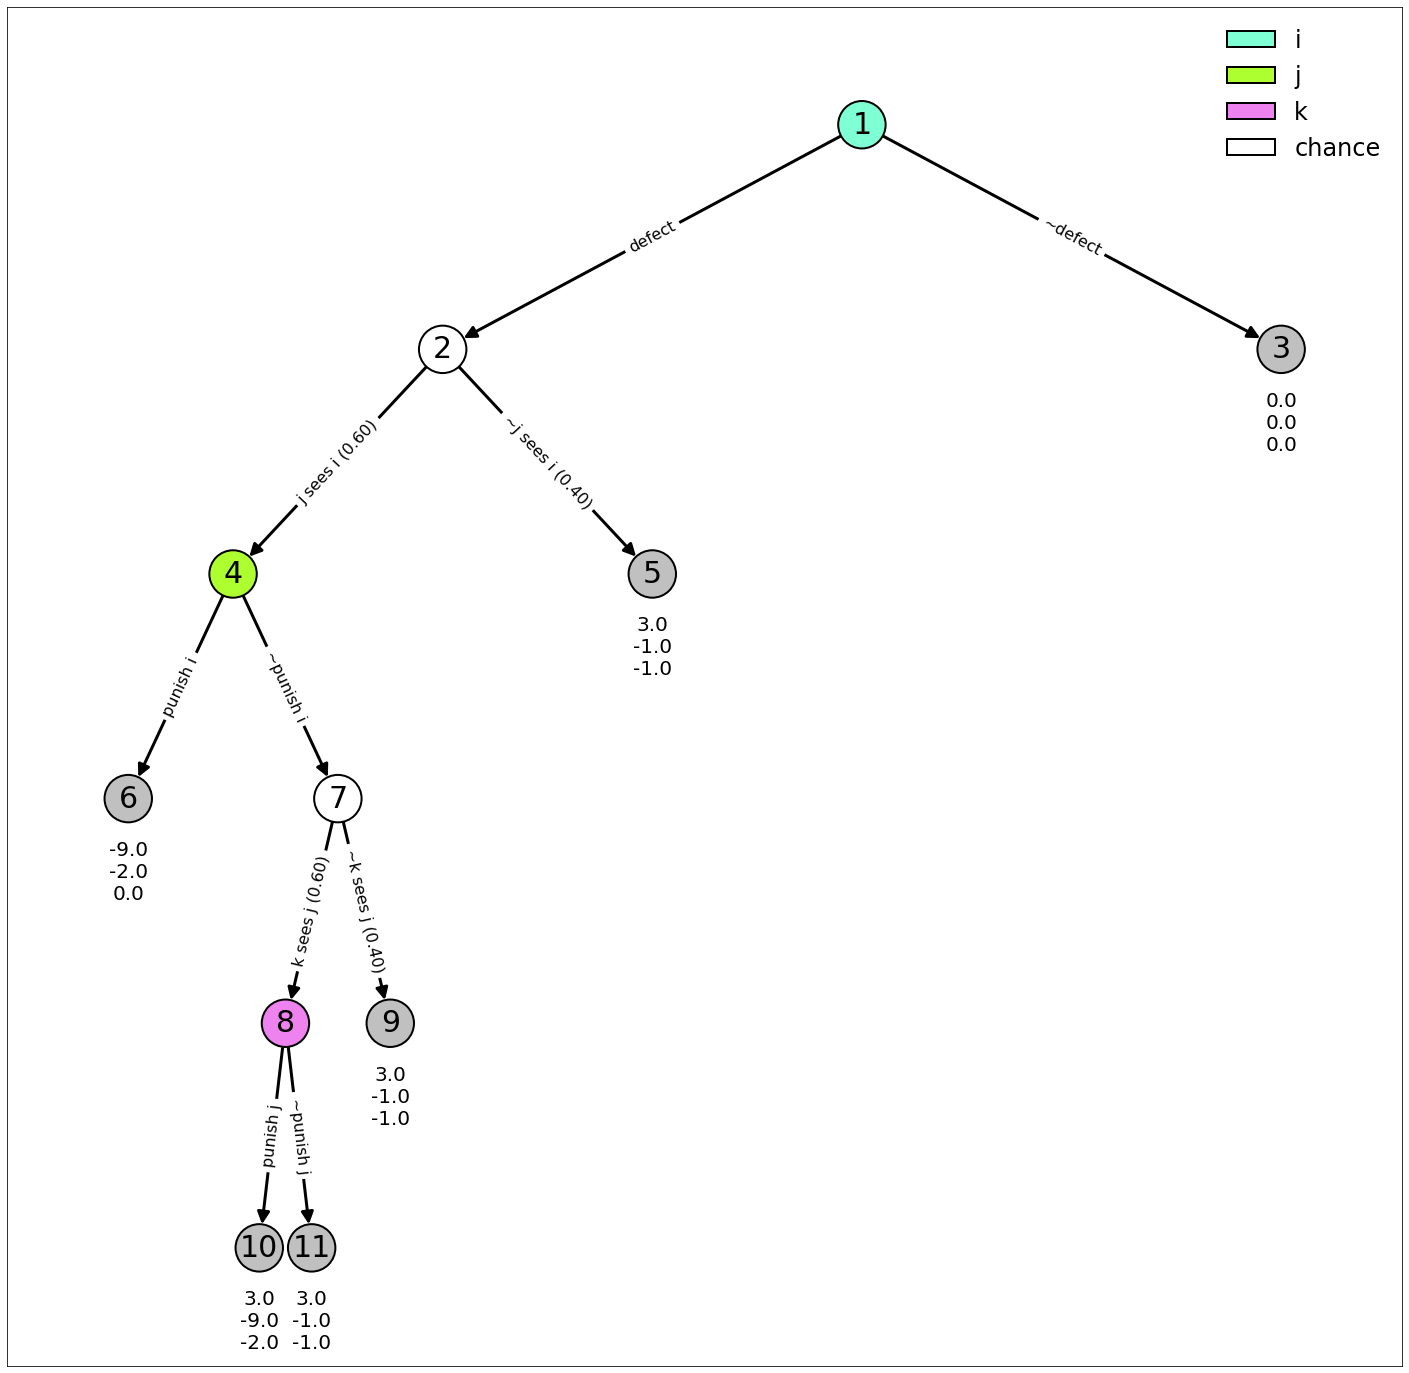

In [30]:
# default keywords for rendering the figure
my_fig_kwargs = dict(figsize=(25, 25), frameon=False)
my_node_kwargs = dict(font_size=30, node_size=2250, edgecolors='k',
                      linewidths=2)
my_edge_kwargs = dict(arrowsize=25, width=3)
my_edge_labels_kwargs = dict(font_size=16)
my_patch_kwargs = dict(linewidth=2)
my_legend_kwargs = dict(fontsize=24, loc='upper right', edgecolor='white')
my_utility_label_kwargs = dict(horizontalalignment='center', fontsize=20)
my_info_sets_kwargs = dict(linestyle='--', linewidth=3)

position_colors =  {'i':'aquamarine', 'j':'greenyellow', 'k':'violet'}

fig = plot_game(metanorms_game,
                position_colors,
                fig_kwargs=my_fig_kwargs,
                node_kwargs=my_node_kwargs,
                edge_kwargs=my_edge_kwargs,
                edge_labels_kwargs=my_edge_labels_kwargs,
                patch_kwargs=my_patch_kwargs,
                legend_kwargs=my_legend_kwargs,
                utility_label_kwargs=my_utility_label_kwargs,
                utility_label_shift=0.09,
                info_sets_kwargs=my_info_sets_kwargs)

fig.savefig('axelrod_metanorms_game.png', bbox_inches='tight', edgecolor=None)

In [31]:
spe = subgame_perfect_equilibrium(metanorms_game)
path_store = []
DFS_equilibria_paths(metanorms_game, metanorms_game.game_tree.root, spe, [], 1, path_store)
print("\nPath -- Probability")
print("-------------------")
for (path, prob) in path_store:
    print("{} -- {:.2f}".format(path, prob))


Path -- Probability
-------------------
[1, 'defect', 2, 'j sees i', 4, '~punish i', 7, 'k sees j', 8, '~punish j', 11] -- 0.36
[1, 'defect', 2, 'j sees i', 4, '~punish i', 7, '~k sees j', 9] -- 0.24
[1, 'defect', 2, '~j sees i', 5] -- 0.40
